In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred
import yfinance as yf
from datetime import datetime

# Step 1: Fetch FRED data
def get_fred_data(api_key, indicators, start_date, end_date):
    """Fetch economic indicators from FRED."""
    print("Step 1: Fetching FRED economic indicators...")
    fred = Fred(api_key=api_key)
    all_series = {}
    for series_id, name in indicators.items():
        print(f"  - Fetching {name} ({series_id})")
        try:
            series = fred.get_series(series_id, observation_start=start_date, observation_end=end_date)
            all_series[series_id] = series
            print(f"    ✓ Got {len(series)} observations")
        except Exception as e:
            print(f"    ✗ Error: {e}")
    if all_series:
        fred_df = pd.DataFrame(all_series)
        print(f"  ✓ Created FRED DataFrame with {len(fred_df)} rows and {len(fred_df.columns)} columns")
        return fred_df
    else:
        print("  ✗ No FRED data was retrieved successfully")
        return None

# Step 2: Fetch S&P 500 data
def get_sp500_data(start_date, end_date):
    """Fetch S&P 500 price data."""
    print("\nStep 2: Fetching S&P 500 price data...")
    try:
        sp500 = yf.download('^GSPC', start=start_date, end=end_date, progress=False)
        sp500 = sp500[['Close']].rename(columns={'SP500': 'SP500'})
        if isinstance(sp500.columns, pd.MultiIndex):
            sp500.columns = ['_'.join(col).strip() for col in sp500.columns.values]
        print(f"  ✓ Got {len(sp500)} days of S&P 500 data")
        return sp500
    except Exception as e:
        print(f"  ✗ Error: {e}")
        return None

# Step 3: Combine FRED and S&P 500 data
def combine_data(sp500_data, fred_data):
    """Combine S&P 500 and FRED data into a single DataFrame."""
    print("\nStep 3: Combining FRED and S&P 500 data...")
    if fred_data is None or sp500_data is None:
        print("  ✗ Missing data, cannot combine")
        return None
    sp500_data.index = pd.to_datetime(sp500_data.index)
    fred_data.index = pd.to_datetime(fred_data.index)
    combined = pd.merge(sp500_data, fred_data, left_index=True, right_index=True, how='outer')
    combined = combined.ffill()
    if 'SP500' not in combined.columns:
        print("  ✗ SP500 column missing from combined dataset")
        if 'SP500' in sp500_data.columns:
            combined = pd.merge(sp500_data, combined, left_index=True, right_index=True, how='right')
            print("  ✓ Re-added SP500 column to combined dataset")
    print(f"  ✓ Combined columns: {', '.join(combined.columns.tolist())}")
    print(f"  ✓ Created combined dataset with {len(combined)} rows and {len(combined.columns)} columns")
    return combined

# Step 4: Calculate correlations
def calculate_correlations(data):
    """Calculate correlations between S&P 500 and economic indicators."""
    print("\nStep 4: Calculating correlations...")
    if 'SP500' not in data.columns:
        print(f"  ✗ SP500 column not found. Available columns: {', '.join(data.columns.tolist())}")
        return None
    clean_data = data.dropna()
    if len(clean_data) < 10:
        print(f"  ✗ Not enough clean data for correlation analysis. Only {len(clean_data)} rows after dropping NaN values.")
        return None
    corr_matrix = clean_data.corr()
    if 'SP500' in corr_matrix.columns:
        sp500_corr = corr_matrix['SP500'].sort_values(ascending=False)
        print("  Correlations with S&P 500:")
        for indicator, corr in sp500_corr.items():
            if indicator != 'SP500':
                print(f"  - {indicator}: {corr:.4f}")
        return sp500_corr
    else:
        print("  ✗ SP500 column not found in correlation matrix")
        return None

# Step 5: Visualize the data
def visualize_data(data, correlations, indicators_dict):
    """Create visualizations to explore relationships."""
    print("\nStep 5: Creating visualizations...")
    if correlations is None or data is None:
        print("  ✗ Missing data, cannot create visualizations")
        return
    clean_data = data.dropna()
    if len(clean_data) < 10:
        print("  ✗ Not enough clean data for visualizations")
        return
    print("  - Generating correlation heatmap")
    plt.figure(figsize=(10, 8))
    sns.heatmap(clean_data.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
    plt.title('Correlation Matrix: S&P 500 and Economic Indicators')
    plt.tight_layout()
    plt.show()
    print("  - Generating time series plot")
    top_indicators = [ind for ind in correlations.index if ind != 'SP500'][:3]
    if not top_indicators:
        print("    ✗ No indicators found for time series plot")
        return
    available_indicators = [ind for ind in top_indicators if ind in clean_data.columns]
    if not available_indicators:
        print("    ✗ None of the top indicators are available in the data")
        return
    plot_cols = ['SP500'] + available_indicators
    plot_data = clean_data[plot_cols].copy()
    normalized_data = pd.DataFrame()
    for col in plot_data.columns:
        col_min = plot_data[col].min()
        col_max = plot_data[col].max()
        if col_max > col_min:
            normalized_data[col] = (plot_data[col] - col_min) / (col_max - col_min)
        else:
            normalized_data[col] = plot_data[col]
    plt.figure(figsize=(12, 6))
    for col in normalized_data.columns:
        plt.plot(normalized_data.index, normalized_data[col], label=indicators_dict.get(col, col))
    plt.title('S&P 500 vs Top Economic Indicators (Normalized)')
    plt.ylabel('Normalized Value')
    plt.legend(title='Indicator')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    print("  - Generating scatter plots")
    if len(available_indicators) > 0:
        fig, axes = plt.subplots(1, len(available_indicators), figsize=(15, 5))
        if len(available_indicators) == 1:
            axes = [axes]
        for i, indicator in enumerate(available_indicators):
            axes[i].scatter(clean_data[indicator], clean_data['SP500'], alpha=0.6)
            axes[i].set_title(f'{indicators_dict.get(indicator, indicator)} vs S&P 500')
            axes[i].set_xlabel(indicators_dict.get(indicator, indicator))
            axes[i].set_ylabel('S&P 500')
            axes[i].grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("    ✗ No indicators available for scatter plots")
    print("  - Generating rolling correlation")
    if len(available_indicators) > 0:
        plt.figure(figsize=(12, 6))
        window = min(60, len(clean_data) // 2)
        for indicator in available_indicators:
            rolling_corr = clean_data['SP500'].rolling(window=window).corr(clean_data[indicator])
            plt.plot(rolling_corr.index, rolling_corr.values, label=indicators_dict.get(indicator, indicator))
        plt.title(f'{window}-Day Rolling Correlation with S&P 500')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("    ✗ No indicators available for rolling correlation")

# Main function
def main():
    fred_api_key = 'a3d347cc6dda1840823eea1d3811efd0'
    start_date = '2019-01-01'
    end_date = '2025-03-31'
    indicators = {
        'DFF': 'Federal Funds Rate',
        'DGS10': '10-Year Treasury Yield',
        'UNRATE': 'Unemployment Rate',
        'CPIAUCSL': 'Consumer Price Index',
        'INDPRO': 'Industrial Production Index',
        'M2SL': 'M2 Money Supply',
        'GDP': 'Gross Domestic Product',
        'UMCSENT': 'Consumer Sentiment'
    }
    fred_data = get_fred_data(fred_api_key, indicators, start_date, end_date)
    sp500_data = get_sp500_data(start_date, end_date)
    combined_data = combine_data(sp500_data, fred_data)
    if combined_data is not None:
        correlations = calculate_correlations(combined_data)
        if correlations is not None:
            visualize_data(combined_data, correlations, indicators)
            print("\nAnalysis complete!")
            print("\nConclusion:")
            top_indicators = [ind for ind in correlations.index if ind != 'SP500'][:3]
            if top_indicators:
                print(f"Based on correlation analysis, the top indicators influencing S&P 500 are:")
                for indicator in top_indicators:
                    corr = correlations[indicator]
                    indicator_name = indicators.get(indicator, indicator)
                    print(f"- {indicator_name} (correlation: {corr:.4f})")
            else:
                print("No significant correlations found.")
        else:
            print("Analysis couldn't be completed due to correlation calculation issues.")
    else:
        print("Analysis couldn't be completed due to data retrieval or combination issues.")
    return combined_data

if __name__ == "__main__":
    combined_data = main()

Step 1: Fetching FRED economic indicators...
  - Fetching Federal Funds Rate (DFF)
    ✓ Got 2278 observations
  - Fetching 10-Year Treasury Yield (DGS10)
    ✓ Got 1628 observations
  - Fetching Unemployment Rate (UNRATE)
    ✓ Got 74 observations
  - Fetching Consumer Price Index (CPIAUCSL)
    ✓ Got 74 observations
  - Fetching Industrial Production Index (INDPRO)
    ✓ Got 74 observations
  - Fetching M2 Money Supply (M2SL)
    ✓ Got 74 observations
  - Fetching Gross Domestic Product (GDP)
    ✓ Got 24 observations
  - Fetching Consumer Sentiment (UMCSENT)
    ✓ Got 74 observations
  ✓ Created FRED DataFrame with 2278 rows and 8 columns

Step 2: Fetching S&P 500 price data...
  ✓ Got 1569 days of S&P 500 data

Step 3: Combining FRED and S&P 500 data...
  ✗ SP500 column missing from combined dataset
  ✓ Combined columns: Close_^GSPC, DFF, DGS10, UNRATE, CPIAUCSL, INDPRO, M2SL, GDP, UMCSENT
  ✓ Created combined dataset with 2279 rows and 9 columns

Step 4: Calculating correlations..

C:\Users\jamal\AppData\Local\Temp\ipykernel_24868\1236955151.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = pd.merge(sp500, bono_10, on='Fecha', how='outer').fillna(method='ffill')


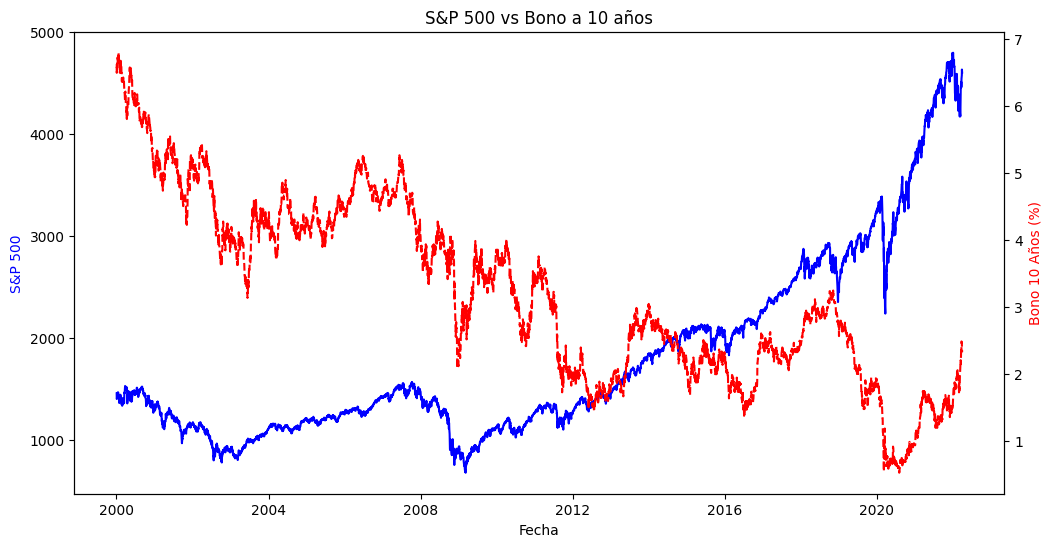

In [127]:
import pandas as pd
import yfinance as yf
from fredapi import Fred
import matplotlib.pyplot as plt

# Parámetros
inicio = '2000-01-01'
fin = '2022-03-31'
fred_api_key = 'a3d347cc6dda1840823eea1d3811efd0'

# Obtener datos del S&P 500
sp500 = yf.download('^GSPC', start=inicio, end=fin, progress=False)[['Close']]
sp500.reset_index(inplace=True)
sp500.columns = ['Fecha', 'SP500']

# Obtener datos del bono a 10 años
fred = Fred(api_key=fred_api_key)
bono_10 = fred.get_series('DGS10', observation_start=inicio, observation_end=fin).reset_index()
bono_10.columns = ['Fecha', 'Bono10']

# Combinar datos
df = pd.merge(sp500, bono_10, on='Fecha', how='outer').fillna(method='ffill')

# Graficar
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

ax1.plot(df['Fecha'], df['SP500'], color='blue', label='S&P 500')
ax2.plot(df['Fecha'], df['Bono10'], color='red', linestyle='dashed', label='Bono 10 Años')

ax1.set_xlabel('Fecha')
ax1.set_ylabel('S&P 500', color='blue')
ax2.set_ylabel('Bono 10 Años (%)', color='red')

plt.title('S&P 500 vs Bono a 10 años')
plt.show()



C:\Users\jamal\AppData\Local\Temp\ipykernel_24868\131922431.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = pd.merge(sp500, cpi, on='Fecha', how='outer').fillna(method='ffill')


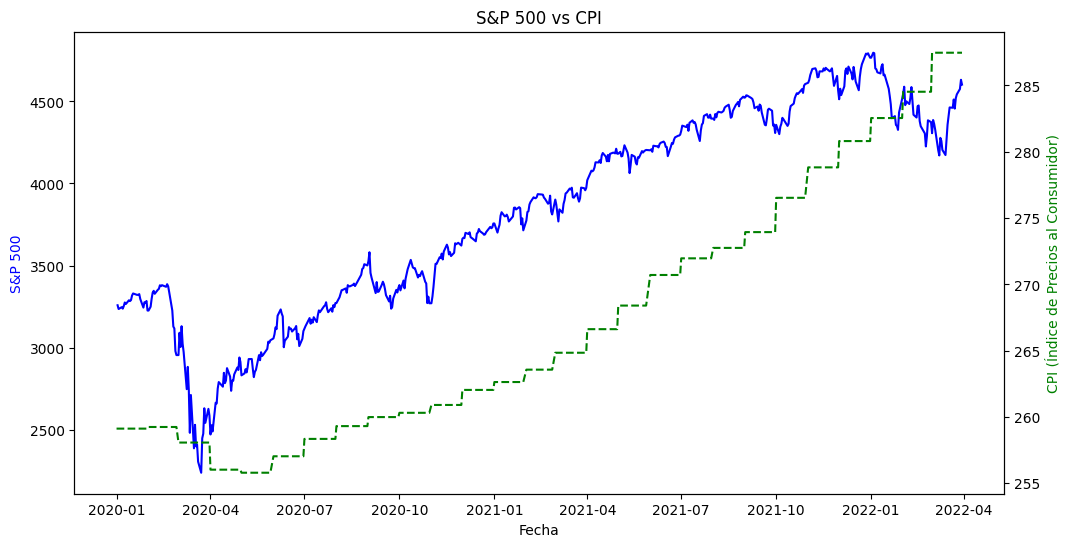

In [128]:
import pandas as pd
import yfinance as yf
from fredapi import Fred
import matplotlib.pyplot as plt

# Parámetros
inicio = '2020-01-01'
fin = '2022-03-31'
fred_api_key = 'a3d347cc6dda1840823eea1d3811efd0'

# Obtener datos del S&P 500
sp500 = yf.download('^GSPC', start=inicio, end=fin, progress=False)[['Close']]
sp500.reset_index(inplace=True)
sp500.columns = ['Fecha', 'SP500']

# Obtener datos del CPI
fred = Fred(api_key=fred_api_key)
cpi = fred.get_series('CPIAUCSL', observation_start=inicio, observation_end=fin).reset_index()
cpi.columns = ['Fecha', 'CPI']

# Combinar datos
df = pd.merge(sp500, cpi, on='Fecha', how='outer').fillna(method='ffill')

# Graficar
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

ax1.plot(df['Fecha'], df['SP500'], color='blue', label='S&P 500')
ax2.plot(df['Fecha'], df['CPI'], color='green', linestyle='dashed', label='CPI')

ax1.set_xlabel('Fecha')
ax1.set_ylabel('S&P 500', color='blue')
ax2.set_ylabel('CPI (Índice de Precios al Consumidor)', color='green')

plt.title('S&P 500 vs CPI')
plt.show()


C:\Users\jamal\AppData\Local\Temp\ipykernel_24868\411055028.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = pd.merge(sp500, cpi, on='Fecha', how='outer').fillna(method='ffill')


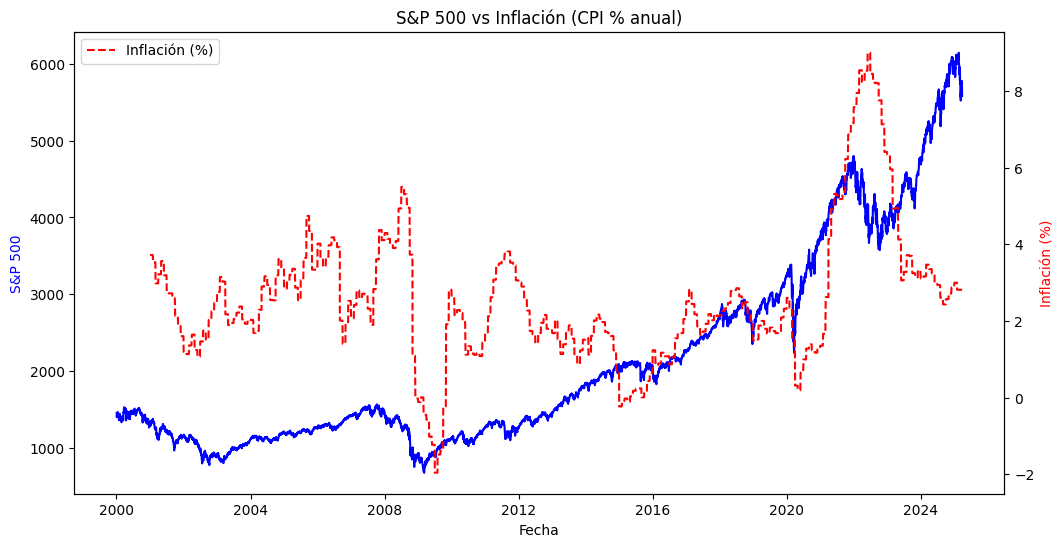

In [131]:
import pandas as pd
import yfinance as yf
from fredapi import Fred
import matplotlib.pyplot as plt

# Parámetros
inicio = '2000-01-01'
fin = '2025-03-31'
fred_api_key = 'a3d347cc6dda1840823eea1d3811efd0'

# Obtener datos del S&P 500
sp500 = yf.download('^GSPC', start=inicio, end=fin, progress=False)[['Close']]
sp500.reset_index(inplace=True)
sp500.columns = ['Fecha', 'SP500']

# Obtener datos del CPI
fred = Fred(api_key=fred_api_key)
cpi = fred.get_series('CPIAUCSL', observation_start=inicio, observation_end=fin).reset_index()
cpi.columns = ['Fecha', 'CPI']

# Calcular inflación interanual (variación % del CPI)
cpi['Inflacion (%)'] = cpi['CPI'].pct_change(12) * 100  # Cambio % anual

# Combinar datos
df = pd.merge(sp500, cpi, on='Fecha', how='outer').fillna(method='ffill')

# Graficar
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

ax1.plot(df['Fecha'], df['SP500'], color='blue', label='S&P 500')
ax2.plot(df['Fecha'], df['Inflacion (%)'], color='red', linestyle='dashed', label='Inflación (%)')

ax1.set_xlabel('Fecha')
ax1.set_ylabel('S&P 500', color='blue')
ax2.set_ylabel('Inflación (%)', color='red')

plt.title('S&P 500 vs Inflación (CPI % anual)')
plt.legend()
plt.show()


C:\Users\jamal\AppData\Local\Temp\ipykernel_24868\4007437218.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Rellenar valores faltantes


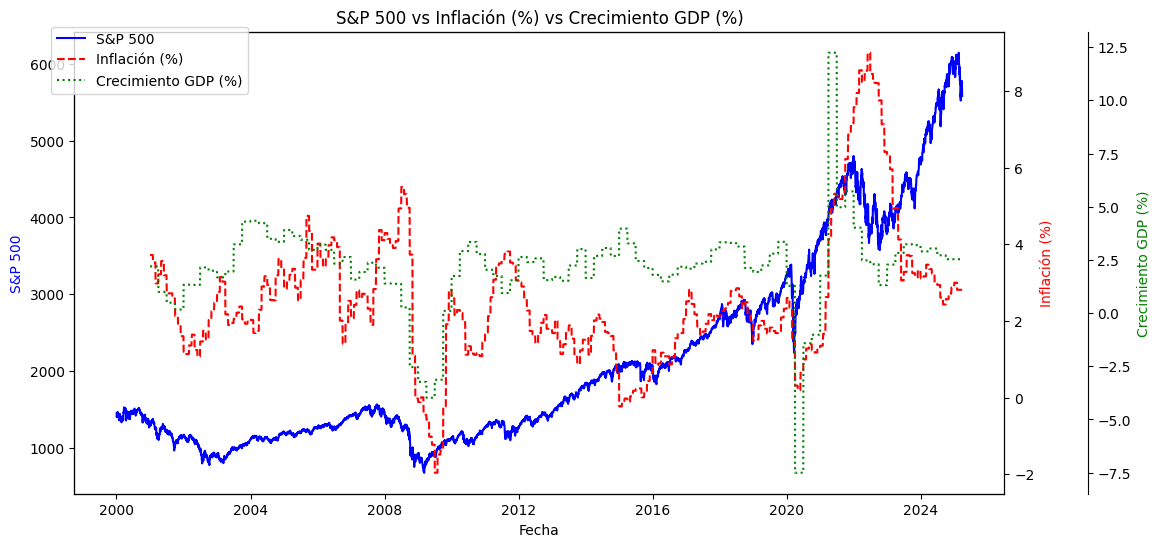

In [133]:
import pandas as pd
import yfinance as yf
from fredapi import Fred
import matplotlib.pyplot as plt

# Parámetros
inicio = '2000-01-01'
fin = '2025-03-31'
fred_api_key = 'a3d347cc6dda1840823eea1d3811efd0'

# Obtener datos del S&P 500
sp500 = yf.download('^GSPC', start=inicio, end=fin, progress=False)[['Close']]
sp500.reset_index(inplace=True)
sp500.columns = ['Fecha', 'SP500']

# Obtener datos de CPI (Índice de Precios al Consumidor)
fred = Fred(api_key=fred_api_key)
cpi = fred.get_series('CPIAUCSL', observation_start=inicio, observation_end=fin).reset_index()
cpi.columns = ['Fecha', 'CPI']
cpi['Inflacion (%)'] = cpi['CPI'].pct_change(12) * 100  # Variación % anual

# Obtener datos de GDP (Producto Interno Bruto real)
gdp = fred.get_series('GDPC1', observation_start=inicio, observation_end=fin).reset_index()
gdp.columns = ['Fecha', 'GDP']
gdp['Crecimiento GDP (%)'] = gdp['GDP'].pct_change(4) * 100  # Cambio % anual (datos trimestrales)

# Combinar los datos
df = pd.merge(sp500, cpi[['Fecha', 'Inflacion (%)']], on='Fecha', how='outer')
df = pd.merge(df, gdp[['Fecha', 'Crecimiento GDP (%)']], on='Fecha', how='outer')
df.fillna(method='ffill', inplace=True)  # Rellenar valores faltantes

# Graficar
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()
ax3 = ax1.twinx()

ax1.plot(df['Fecha'], df['SP500'], color='blue', label='S&P 500')
ax2.plot(df['Fecha'], df['Inflacion (%)'], color='red', linestyle='dashed', label='Inflación (%)')
ax3.plot(df['Fecha'], df['Crecimiento GDP (%)'], color='green', linestyle='dotted', label='Crecimiento GDP (%)')

ax1.set_xlabel('Fecha')
ax1.set_ylabel('S&P 500', color='blue')
ax2.set_ylabel('Inflación (%)', color='red')
ax3.spines["right"].set_position(("outward", 60))
ax3.set_ylabel('Crecimiento GDP (%)', color='green')

plt.title('S&P 500 vs Inflación (%) vs Crecimiento GDP (%)')
fig.legend(loc="upper left", bbox_to_anchor=(0.1,0.9))
plt.show()


C:\Users\jamal\AppData\Local\Temp\ipykernel_24868\4245617175.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Rellenar valores faltantes


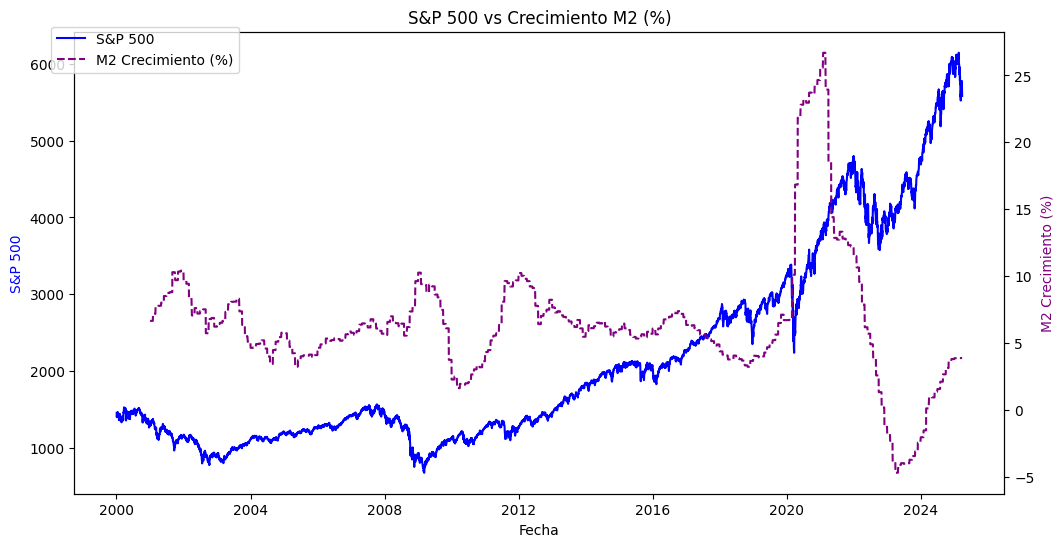

In [135]:
import pandas as pd
import yfinance as yf
from fredapi import Fred
import matplotlib.pyplot as plt

# Parámetros
inicio = '2000-01-01'
fin = '2025-03-31'
fred_api_key = 'a3d347cc6dda1840823eea1d3811efd0'

# Obtener datos del S&P 500
sp500 = yf.download('^GSPC', start=inicio, end=fin, progress=False)[['Close']]
sp500.reset_index(inplace=True)
sp500.columns = ['Fecha', 'SP500']

# Obtener datos de M2 Money Supply
fred = Fred(api_key=fred_api_key)
m2 = fred.get_series('M2SL', observation_start=inicio, observation_end=fin).reset_index()
m2.columns = ['Fecha', 'M2']
m2['M2 Crecimiento (%)'] = m2['M2'].pct_change(12) * 100  # Variación % anual

# Combinar los datos
df = pd.merge(sp500, m2[['Fecha', 'M2 Crecimiento (%)']], on='Fecha', how='outer')
df.fillna(method='ffill', inplace=True)  # Rellenar valores faltantes

# Graficar
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()

ax1.plot(df['Fecha'], df['SP500'], color='blue', label='S&P 500')
ax2.plot(df['Fecha'], df['M2 Crecimiento (%)'], color='purple', linestyle='dashed', label='M2 Crecimiento (%)')

ax1.set_xlabel('Fecha')
ax1.set_ylabel('S&P 500', color='blue')
ax2.set_ylabel('M2 Crecimiento (%)', color='purple')

plt.title('S&P 500 vs Crecimiento M2 (%)')
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
plt.show()
